In [11]:
# Cell 1: Setup, load, quick EDA
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, warnings
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, log_loss, confusion_matrix, roc_curve, auc
)

warnings.filterwarnings('ignore')
%matplotlib inline

PATH = 'E:/Projects/CBK_Assignment/Greenland_Registry/ethereum_raw.csv'   # adjust if different
df = pd.read_csv(PATH)
df.columns = [c.strip() for c in df.columns]

print("Rows:", len(df), "Columns:", len(df.columns))
display(df.head(3))
print("\nColumn sample:", df.columns.tolist()[:40])

# target check
target_candidates = [c for c in df.columns if c.strip().lower() in ('flag','flg','label','isfraud')]
if not target_candidates:
    raise ValueError("No target column found. Rename/verify your target (FLAG).")
target_col = target_candidates[0]
print("Using target column:", target_col)

# class distribution
dist = df[target_col].value_counts()
print("\nClass counts:\n", dist)
print("\nClass proportions:\n", (dist / dist.sum()).rename("proportion"))


Rows: 9841 Columns: 51


,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON



Column sample: ['Unnamed: 0', 'Index', 'Address', 'FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', 'Total ERC20 tnxs', 'ERC20 total Ether received', 'ERC20 total ether sent', 'ERC20 total Ether sent contract', 'ERC20 uniq sent addr', 'ERC20 uniq rec addr', 'ERC20 uniq sent addr.1', 'ERC20 uniq rec contract addr', 'ERC20 avg time between sent tnx', 'ERC20 avg time between rec tnx', 'ERC20 avg time between rec 2 tnx', 'ERC20 avg time between contract tnx', 'ERC

In [13]:
# Cell 2: Cleaning & remove ID-like leak columns
df2 = df.copy()

# Drop duplicates if any
if 'tx_hash' in df2.columns:
    df2 = df2.drop_duplicates(subset=['tx_hash'])

# identify obvious ID columns
id_like = [c for c in df2.columns if c.lower() in ('address','addr','wallet','account')]
print("Detected id-like columns:", id_like)

# drop them from features (keep in original df if needed)
df2 = df2.drop(columns=[c for c in id_like if c in df2.columns], errors='ignore')

# Drop "Unnamed" and other index artifacts that leak information
leak_cols = [c for c in df2.columns if 'unnamed' in c.lower() or 'index' == c.lower()]
print("Dropping leakage columns (if present):", leak_cols)
df2 = df2.drop(columns=leak_cols, errors='ignore')

# show remaining
print("After cleanup, columns:", len(df2.columns))
display(df2.head(2))


Detected id-like columns: ['Address']
Dropping leakage columns (if present): ['Unnamed: 0', 'Index']
After cleanup, columns: 48


,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,844.26,1093.71,704785.63,721,89,0,40,118,0.0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token


In [14]:
# Cell 3: Convert numeric-like strings, frequency-encode object cols, scale numeric
from sklearn.preprocessing import RobustScaler

df_proc = df2.copy()

# Try coercion for object columns that look numeric
for c in df_proc.columns:
    if df_proc[c].dtype == object:
        cleaned = df_proc[c].astype(str).str.replace(',','').str.strip()
        coerced = pd.to_numeric(cleaned, errors='coerce')
        # keep if many values convert
        if coerced.notna().sum() / max(1, len(coerced)) > 0.6:
            df_proc[c] = coerced

# Identify target & features
y = df_proc[target_col].astype(int)
X = df_proc.drop(columns=[target_col])

# Categorical detection
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in numeric_cols]

print("Numeric cols:", len(numeric_cols), "Categorical cols:", len(cat_cols))

# Frequency encode categorical columns (simple, no leakage)
for c in cat_cols:
    X[c] = X[c].fillna('NA').astype(str)
    vc = X[c].value_counts()
    X[c + '_freqenc'] = X[c].map(vc).fillna(0).astype(float)
# drop original cat cols
X = X.drop(columns=cat_cols)

# recompute numeric list
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# fillna numeric
X[numeric_cols] = X[numeric_cols].fillna(0.0)

# scale
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[numeric_cols]), columns=numeric_cols, index=X.index)
print("Processed feature matrix shape:", X_scaled.shape)


Numeric cols: 45 Categorical cols: 2
Processed feature matrix shape: (9841, 47)


In [ ]:
# Cell 4: sanitize column names and save mapping
import re, json
def sanitize(name):
    s = re.sub(r'[^0-9a-zA-Z]', '_', str(name))
    s = re.sub(r'__+', '_', s).strip('_')
    if s == '': s = 'col'
    return s

orig_cols = X_scaled.columns.tolist()
mapping = {}
seen = {}
new_cols = []
for c in orig_cols:
    new = sanitize(c)
    if new in seen:
        seen[new] += 1
        new = f"{new}_{seen[new]}"
    else:
        seen[new] = 0
    mapping[c] = new
    new_cols.append(new)

X_scaled.columns = new_cols
# If X_train/X_test already exist later, we'll map them similarly
# with open('/mnt/data/colname_mapping.json', 'w') as f:
#     json.dump(mapping, f, indent=2)
# print("Sanitized columns, sample mapping (first 20):")
# for k,v in list(mapping.items())[:20]:
#     print(f"'{k}' -> '{v}'")
# print("\nSaved mapping to /mnt/data/colname_mapping.json")


In [16]:
# Cell 5: Train/test and baseline modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import time

RSTATE = 42
X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.20, stratify=y, random_state=RSTATE)
print("Train/test shapes:", X_tr.shape, X_te.shape)

results = []

def eval_model(name, model):
    t0 = time.time()
    # try predict_proba
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(X_te)[:,1]
    else:
        # fallback to predict
        preds = model.predict(X_te)
        proba = preds.astype(float)
    preds_bin = (proba >= 0.5).astype(int)
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
    can_proba = (proba.min() >= 0.0) and (proba.max() <= 1.0) and ((proba != 0).any() or (proba != 1).any())
    res = {
        'model': name,
        'accuracy': accuracy_score(y_te, preds_bin),
        'precision': precision_score(y_te, preds_bin, zero_division=0),
        'recall': recall_score(y_te, preds_bin, zero_division=0),
        'f1': f1_score(y_te, preds_bin, zero_division=0),
        'roc_auc': roc_auc_score(y_te, proba) if can_proba else np.nan,
        'log_loss': log_loss(y_te, proba) if can_proba else np.nan,
        'time_sec': round(time.time() - t0, 3)
    }
    return res

# Logistic Regression
print("Training LogisticRegression...")
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RSTATE)
lr.fit(X_tr, y_tr)
results.append(eval_model('LogisticRegression', lr))

# RandomForest
print("Training RandomForest...")
rf = RandomForestClassifier(n_estimators=200, max_depth=12, class_weight='balanced', random_state=RSTATE, n_jobs=-1)
rf.fit(X_tr, y_tr)
results.append(eval_model('RandomForest', rf))

# XGBoost
print("Training XGBoost...")
xgb_clf = xgb.XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=RSTATE, n_jobs=-1)
xgb_clf.fit(X_tr, y_tr)
results.append(eval_model('XGBoost', xgb_clf))

# LightGBM
print("Training LightGBM...")
lgb_clf = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, class_weight='balanced', random_state=RSTATE, n_jobs=-1)
lgb_clf.fit(X_tr, y_tr)
results.append(eval_model('LightGBM', lgb_clf))

res_df = pd.DataFrame(results).set_index('model').sort_values('roc_auc', ascending=False)
display(res_df)


Train/test shapes: (7872, 47) (1969, 47)
Training LogisticRegression...
Training RandomForest...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Number of positive: 1743, number of negative: 6129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6763
[LightGBM] [Info] Number of data points in the train set: 7872, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

,accuracy,precision,recall,f1,roc_auc,log_loss,time_sec
model,,,,,,,
LightGBM,0.994921,0.997664,0.979358,0.988426,0.999503,0.027278,0.047
XGBoost,0.995429,1.000000,0.979358,0.989571,0.999270,0.019361,0.034
RandomForest,0.985780,0.992754,0.942661,0.967059,0.999078,0.048624,0.057
LogisticRegression,0.781107,0.504472,0.646789,0.566834,0.826189,0.708492,0.015


,accuracy,precision,recall,f1,roc_auc,log_loss,time_sec
model,,,,,,,
LightGBM,0.994921,0.997664,0.979358,0.988426,0.999503,0.027278,0.047
XGBoost,0.995429,1.000000,0.979358,0.989571,0.999270,0.019361,0.034
RandomForest,0.985780,0.992754,0.942661,0.967059,0.999078,0.048624,0.057
LogisticRegression,0.781107,0.504472,0.646789,0.566834,0.826189,0.708492,0.015


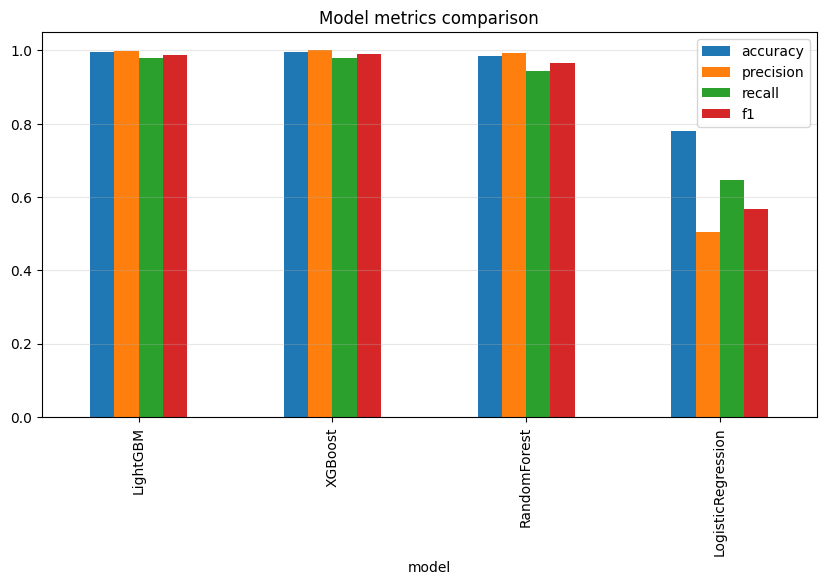

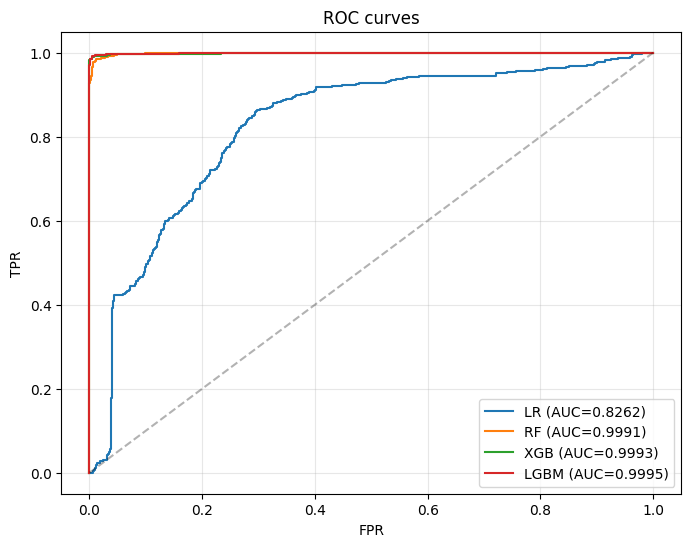

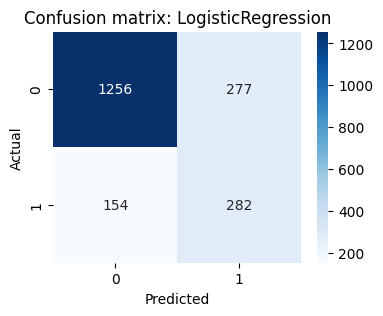

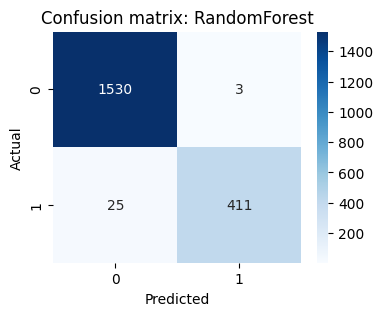

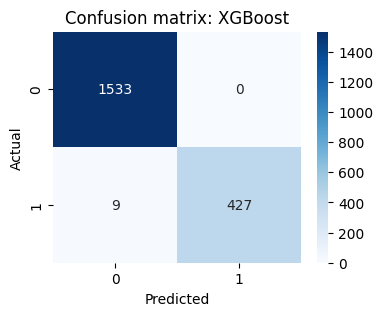

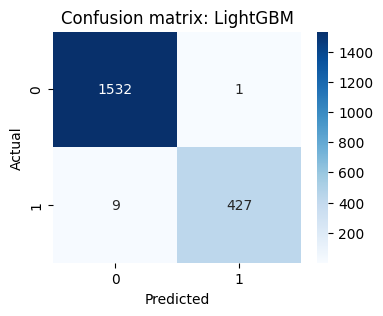

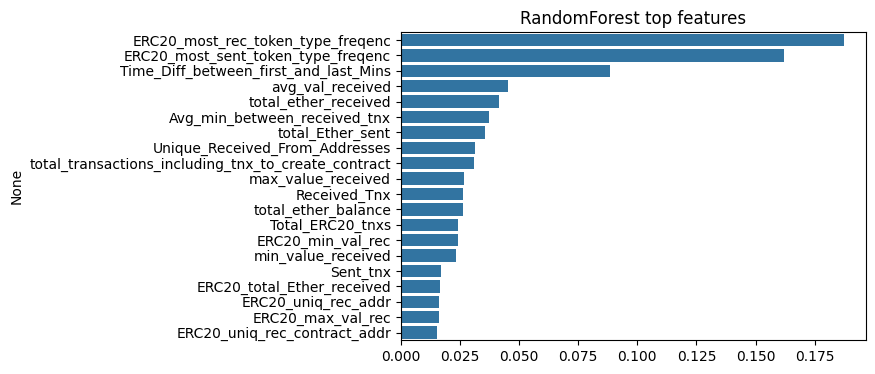

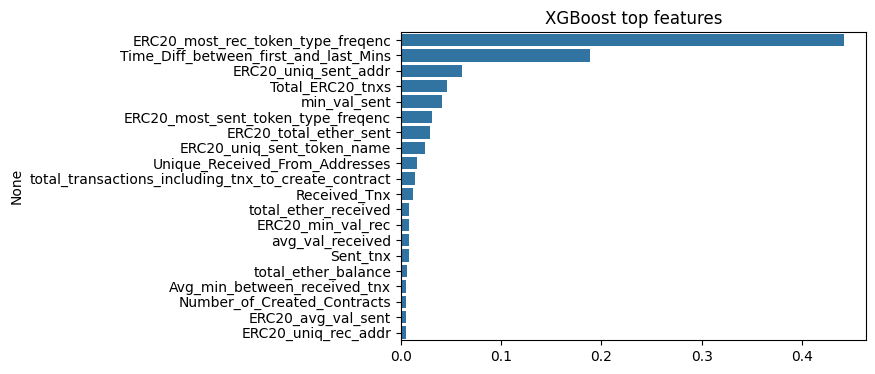

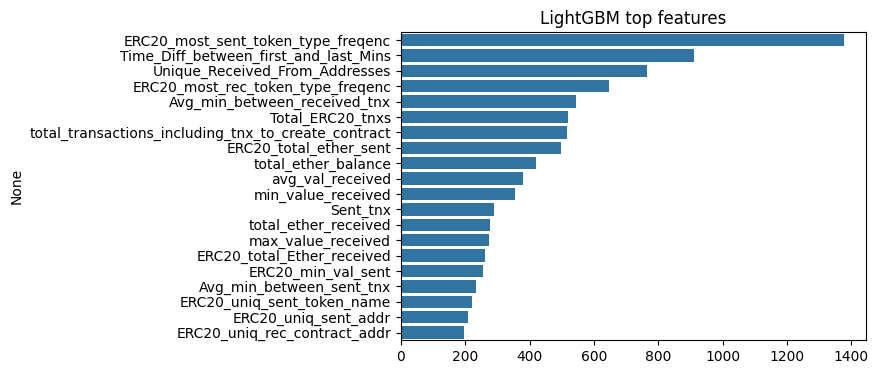

In [17]:
# Cell 6: Visual evaluation
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# 1) Metrics bar chart (accuracy/precision/recall/f1)
display(res_df)
metrics_plot = res_df[['accuracy','precision','recall','f1']].plot(kind='bar', figsize=(10,5))
plt.title("Model metrics comparison")
plt.ylim(0,1.05)
plt.grid(axis='y', alpha=0.3)
plt.show()

# 2) ROC curves for models that support predict_proba
plt.figure(figsize=(8,6))
for name, model in [('LR', lr), ('RF', rf), ('XGB', xgb_clf), ('LGBM', lgb_clf)]:
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(X_te)[:,1]
        fpr, tpr, _ = roc_curve(y_te, proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.4f})")
plt.plot([0,1],[0,1],'k--', alpha=0.3)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC curves")
plt.legend(); plt.grid(alpha=0.3); plt.show()

# 3) Confusion matrices
for name, model in [('LogisticRegression', lr), ('RandomForest', rf), ('XGBoost', xgb_clf), ('LightGBM', lgb_clf)]:
    if hasattr(model,'predict_proba'):
        ypred = (model.predict_proba(X_te)[:,1] >= 0.5).astype(int)
    else:
        ypred = model.predict(X_te)
    cm = confusion_matrix(y_te, ypred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion matrix: {name}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

# 4) Feature importances (RF/XGB/LGBM)
def plot_top_importances(model, name, top=20):
    if hasattr(model, 'feature_importances_'):
        imp = pd.Series(model.feature_importances_, index=X_scaled.columns).sort_values(ascending=False).head(top)
        plt.figure(figsize=(6,4)); sns.barplot(x=imp.values, y=imp.index); plt.title(f"{name} top features"); plt.show()
    elif hasattr(model, 'coef_'):
        coef = pd.Series(np.abs(model.coef_).ravel(), index=X_scaled.columns).sort_values(ascending=False).head(top)
        plt.figure(figsize=(6,4)); sns.barplot(x=coef.values, y=coef.index); plt.title(f"{name} top coefs"); plt.show()
    else:
        print("No importances for", name)

plot_top_importances(rf, "RandomForest")
plot_top_importances(xgb_clf, "XGBoost")
plot_top_importances(lgb_clf, "LightGBM")


In [18]:
# Cell 7: Stratified K-Fold CV to check stability (use small folds, e.g., 5)
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = [('LightGBM', lgb.LGBMClassifier(n_estimators=200, learning_rate=0.05, class_weight='balanced', random_state=42))]

cv_results = []
for name, model in models:
    aucs = []
    for tr_idx, val_idx in skf.split(X_scaled, y):
        model.fit(X_scaled.iloc[tr_idx], y.iloc[tr_idx])
        proba = model.predict_proba(X_scaled.iloc[val_idx])[:,1]
        aucs.append(roc_auc_score(y.iloc[val_idx], proba))
    print(f"{name} CV AUCs: mean={np.mean(aucs):.4f} std={np.std(aucs):.4f}")
    cv_results.append({'model':name, 'mean_auc':np.mean(aucs), 'std_auc':np.std(aucs)})
pd.DataFrame(cv_results).set_index('model')


[LightGBM] [Info] Number of positive: 1743, number of negative: 6129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6751
[LightGBM] [Info] Number of data points in the train set: 7872, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1744, number of negative: 6129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 7873, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM]

,mean_auc,std_auc
model,,
LightGBM,0.999634,0.00023


In [19]:
# Cell 8: Save processed features (fallback to CSV if pyarrow parquet issues)
out_parquet = 'E:/Projects/CBK_Assignment/Greenland_Registry/Results/ethereum_baseline_features.parquet'
out_csv = 'E:/Projects/CBK_Assignment/Greenland_Registry/Results/ethereum_baseline_features.csv'
try:
    X_scaled.to_parquet(out_parquet, index=False, engine='fastparquet')
    print("Saved parquet:", out_parquet)
except Exception as e:
    print("Parquet save failed:", e, "— saving CSV instead.")
    X_scaled.to_csv(out_csv, index=False)
    print("Saved CSV:", out_csv)


Saved parquet: E:/Projects/CBK_Assignment/Greenland_Registry/Results/ethereum_baseline_features.parquet
